In [1]:
from time import perf_counter
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from joblib import Parallel, delayed
import os

import src.utils as utils
from src.model import MetMulDagma, MetMulColide

from baselines.colide import colide_ev
from baselines.dagma_linear import DAGMA_linear
from baselines.notears import notears_linear


PATH = './results/samples/'
SAVE = True 
SEED = 10
N_CPUS = os.cpu_count()
np.random.seed(SEED)

## Auxiliary functions

In [2]:
# Experiment function
def get_lamb_value(n_nodes, n_samples, times=1):
    return np.sqrt(np.log(n_nodes) / n_samples) * times 

def run_samples_exp(g, data_p, N_samples, exps, thr=.2, verb=False):
    shd, tpr, fdr, fscore, err, acyc, runtime, dag_count = [np.zeros((len(N_samples), len(exps)))  for _ in range(8)]
    for i, n_samples in enumerate(N_samples):
        if g % N_CPUS == 0:
            print(f'Graph: {g+1}, samples: {n_samples}')

        # Create data
        data_p_aux = data_p.copy()
        data_p_aux['n_samples'] = n_samples

        W_true, _, X = utils.simulate_sem(**data_p_aux)
        X_std = utils.standarize(X)
        W_true_bin = utils.to_bin(W_true, thr)
        norm_W_true = np.linalg.norm(W_true)

        for j, exp in enumerate(exps):
            X_aux = X_std if 'standarize' in exp.keys() and exp['standarize'] else X


            arg_aux = exp['args'].copy()
            if 'adapt_lamb' in exp.keys() and exp['adapt_lamb']:
                if 'lamb' in arg_aux.keys():
                    arg_aux['lamb'] = get_lamb_value(data_p['n_nodes'], n_samples, arg_aux['lamb'])
                elif 'lambda1' in arg_aux.keys():
                    arg_aux['lambda1'] = get_lamb_value(data_p['n_nodes'], n_samples, arg_aux['lambda1'])

            if exp['model'] == notears_linear:
                t_init = perf_counter()
                W_est = notears_linear(X_aux, **arg_aux)
                t_end = perf_counter()
            else:
                model = exp['model'](**exp['init']) if 'init' in exp.keys() else exp['model']()
                t_init = perf_counter()
                model.fit(X_aux, **arg_aux)
                t_end = perf_counter()
                
                W_est = model.W_est

            if np.isnan(W_est).any():
                W_est = np.zeros_like(W_est)
                W_est_bin = np.zeros_like(W_est)
            else:
                W_est_bin = utils.to_bin(W_est, thr)
            
            shd[i,j], tpr[i,j], fdr[i,j] = utils.count_accuracy(W_true_bin, W_est_bin)
            fscore[i,j] = f1_score(W_true_bin.flatten(), W_est_bin.flatten())
            err[i,j] = utils.compute_norm_sq_err(W_true, W_est, norm_W_true)
            acyc[i,j] = model.dagness(W_est) if hasattr(model, 'dagness') else 1
            runtime[i,j] = t_end - t_init
            dag_count[i,j] += 1 if utils.is_dag(W_est_bin) else 0
        
            if verb and (g % N_CPUS == 0):
                print(f'\t-{exp["leg"]}: shd {shd[i,j]}  -  err: {err[i,j]:.3f}  -  time: {runtime[i,j]:.3f}')

    return shd, tpr, fdr, fscore, err, acyc, runtime, dag_count


## Without standarizing

In [6]:
n_dags = 50
N_samples = np.array( [50, 60, 80, 100, 200, 500, 1000, 5000] )

# DEFINE EXPERIMENTS
Exps = [
  # MM + Cvx DAGMA
  {'model': MetMulDagma, 'args': {'stepsize': 3e-4, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': 1e-1,
   'iters_in': 10000, 'iters_out': 10, 'beta': 2}, 'init': {'primal_opt': 'adam', 'acyclicity': 'logdet'},
   'adapt_lamb': True, 'standarize': False, 'fmt': 'o-', 'leg': 'MM-Logdet'},

  {'model': MetMulDagma, 'args': {'stepsize': 1e-5, 'alpha_0': .01, 'rho_0': .01, 's': 1, 'lamb': .2, 'iters_in': 5000,
     'iters_out': 50, 'beta': 1.5}, 'init': {'acyclicity': 'logdet', 'primal_opt': 'fista', 'restart': True},
     'adapt_lamb': True, 'standarize': False, 'fmt': 'o--', 'leg': 'MM-fista'},

   ## MM + CvxNoTears
  {'model': MetMulDagma, 'args': {'stepsize': 1e-5, 'alpha_0': 1, 'rho_0': 10, 's': 1, 'lamb': .1, 'iters_in': 10000,
   'iters_out': 10, 'beta': 5, 'tol': 1e-5}, 'init': {'acyclicity': 'matexp', 'primal_opt': 'fista'},
   'adapt_lamb': True, 'standarize': False, 'fmt': 'x-', 'leg': 'MM-Matexp'},

  # MM + Cvx COLIDE
  {'model': MetMulColide, 'args': {'stepsize': 3e-4, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': .1, 'iters_in': 20000,
     'iters_out': 10, 'beta': 2, 'sca_adam': True}, 'init': {'acyclicity': 'logdet', 'primal_opt': 'sca'},
     'adapt_lamb': True, 'standarize': False, 'fmt': 's-', 'leg': 'MM-Col-sca'},


  # Colide
  {'model': colide_ev, 'args': {'lambda1': .05, 'T': 4, 's': [1.0, .9, .8, .7], 'warm_iter': 2e4,
   'max_iter': 7e4, 'lr': .0003}, 'standarize': False, 'fmt': 'v--', 'leg': 'CoLiDe-Fix'},

  {'model': colide_ev, 'args': {'lambda1': .05, 'T': 4, 's': [1.0, .9, .8, .7], 'warm_iter': 2e4,
   'max_iter': 7e4, 'lr': .0003}, 'standarize': False, 'adapt_lamb': True, 'fmt': 'v-', 'leg': 'CoLiDe'},

  # DAGMA
  {'model': DAGMA_linear, 'init': {'loss_type': 'l2'}, 'args': {'lambda1': .05, 'T': 4, 's': [1.0, .9, .8, .8],
   'warm_iter': 2e4, 'max_iter': 7e4, 'lr': .0003}, 'standarize': False, 'fmt': '^-', 'leg': 'DAGMA'},

  # NoTears
  {'model': notears_linear, 'args': {'loss_type': 'l2', 'lambda1': .1, 'max_iter': 4}, 'standarize': False,  'fmt': '>-', 'leg': 'NoTears'},
]

### 100 nodes - unit variance

In [4]:
N = 100
thr = .2
verb = True
data_p = {
    'n_nodes': N,
    'graph_type': 'er',
    'edges': 4*N,
    'edge_type': 'positive',
    'w_range': (.5, 1),
    'var': 1,
}

shd, tpr, fdr, fscore, err, acyc, runtime, dag_count =\
      [np.zeros((n_dags, len(N_samples), len(Exps)))  for _ in range(8)]

print('CPUs employed:', N_CPUS)

t_init = perf_counter()
results = Parallel(n_jobs=N_CPUS)(delayed(run_samples_exp)
                                  (g, data_p, N_samples, Exps, thr, verb) for g in range(n_dags))
t_end = perf_counter()
print(f'----- Solved in {(t_end-t_init)/60:.3f} minutes -----')
shd, tpr, fdr, fscore, err, acyc, runtime, dag_count = zip(*results)


CPUs employed: 128


Graph: 1, samples: 50
	-MM-Logdet: shd 155.0  -  err: 0.202  -  time: 28.262
	-MM-fista: shd 111.0  -  err: 0.239  -  time: 16.483


/usr/local/lib/python3.8/dist-packages/scipy/linalg/_matfuncs.py:375: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/usr/local/lib/python3.8/dist-packages/scipy/linalg/_matfuncs.py:375: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw
/usr/local/lib/python3.8/dist-packages/scipy/linalg/_matfuncs.py:375: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


	-MM-Matexp: shd 205.0  -  err: 0.286  -  time: 55.443
	-MM-Col-sca: shd 196.0  -  err: 0.244  -  time: 25.857
	-CoLiDe-Fix: shd 631.0  -  err: 0.734  -  time: 60.439
	-CoLiDe: shd 1167.0  -  err: 0.999  -  time: 46.979
	-DAGMA: shd 435.0  -  err: 0.642  -  time: 23.385
	-NoTears: shd 258.0  -  err: 0.700  -  time: 43.321
Graph: 1, samples: 60
	-MM-Logdet: shd 110.0  -  err: 0.137  -  time: 27.253
	-MM-fista: shd 68.0  -  err: 0.138  -  time: 16.169


/usr/local/lib/python3.8/dist-packages/scipy/linalg/_matfuncs.py:375: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


	-MM-Matexp: shd 437.0  -  err: 1.000  -  time: 188.429
	-MM-Col-sca: shd 126.0  -  err: 0.155  -  time: 38.868
	-CoLiDe-Fix: shd 708.0  -  err: 0.761  -  time: 54.419
	-CoLiDe: shd 1342.0  -  err: 1.006  -  time: 46.821
	-DAGMA: shd 469.0  -  err: 0.615  -  time: 38.174
	-NoTears: shd 352.0  -  err: 0.988  -  time: 40.057
Graph: 1, samples: 80
	-MM-Logdet: shd 66.0  -  err: 0.117  -  time: 19.327
	-MM-fista: shd 50.0  -  err: 0.123  -  time: 16.048
	-MM-Matexp: shd 91.0  -  err: 0.153  -  time: 26.580


/usr/local/lib/python3.8/dist-packages/scipy/linalg/_matfuncs.py:375: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/usr/local/lib/python3.8/dist-packages/scipy/linalg/_matfuncs.py:375: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


	-MM-Col-sca: shd 89.0  -  err: 0.134  -  time: 21.369
	-CoLiDe-Fix: shd 263.0  -  err: 0.334  -  time: 27.330
	-CoLiDe: shd 1111.0  -  err: 0.717  -  time: 37.332
	-DAGMA: shd 178.0  -  err: 0.276  -  time: 18.443
	-NoTears: shd 140.0  -  err: 0.359  -  time: 42.750
Graph: 1, samples: 100
	-MM-Logdet: shd 35.0  -  err: 0.062  -  time: 17.793
	-MM-fista: shd 22.0  -  err: 0.062  -  time: 17.564
	-MM-Matexp: shd 50.0  -  err: 0.096  -  time: 26.583
	-MM-Col-sca: shd 41.0  -  err: 0.075  -  time: 20.106
	-CoLiDe-Fix: shd 94.0  -  err: 0.170  -  time: 22.757
	-CoLiDe: shd 850.0  -  err: 0.525  -  time: 24.888
	-DAGMA: shd 82.0  -  err: 0.158  -  time: 16.640
	-NoTears: shd 76.0  -  err: 0.195  -  time: 25.837
Graph: 1, samples: 200
	-MM-Logdet: shd 4.0  -  err: 0.026  -  time: 19.351
	-MM-fista: shd 5.0  -  err: 0.025  -  time: 17.766
	-MM-Matexp: shd 29.0  -  err: 0.064  -  time: 35.236
	-MM-Col-sca: shd 6.0  -  err: 0.029  -  time: 19.610


/usr/local/lib/python3.8/dist-packages/scipy/linalg/_matfuncs.py:375: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/usr/local/lib/python3.8/dist-packages/scipy/linalg/_matfuncs.py:375: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


	-CoLiDe-Fix: shd 48.0  -  err: 0.120  -  time: 21.207


/usr/local/lib/python3.8/dist-packages/scipy/linalg/_matfuncs.py:375: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/usr/local/lib/python3.8/dist-packages/scipy/linalg/_matfuncs.py:375: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


	-CoLiDe: shd 281.0  -  err: 0.254  -  time: 25.261
	-DAGMA: shd 51.0  -  err: 0.119  -  time: 16.916


/usr/local/lib/python3.8/dist-packages/scipy/linalg/_matfuncs.py:375: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/usr/local/lib/python3.8/dist-packages/scipy/linalg/_matfuncs.py:375: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


	-NoTears: shd 93.0  -  err: 0.237  -  time: 31.746
Graph: 1, samples: 500
	-MM-Logdet: shd 0.0  -  err: 0.010  -  time: 16.080
	-MM-fista: shd 1.0  -  err: 0.012  -  time: 12.051
	-MM-Matexp: shd 8.0  -  err: 0.021  -  time: 12.431
	-MM-Col-sca: shd 0.0  -  err: 0.010  -  time: 17.603
	-CoLiDe-Fix: shd 20.0  -  err: 0.054  -  time: 17.290
	-CoLiDe: shd 51.0  -  err: 0.120  -  time: 21.097
	-DAGMA: shd 15.0  -  err: 0.056  -  time: 13.617
	-NoTears: shd 56.0  -  err: 0.146  -  time: 29.892
Graph: 1, samples: 1000
	-MM-Logdet: shd 0.0  -  err: 0.004  -  time: 18.630
	-MM-fista: shd 0.0  -  err: 0.003  -  time: 11.862
	-MM-Matexp: shd 39.0  -  err: 0.058  -  time: 22.832


/usr/local/lib/python3.8/dist-packages/scipy/linalg/_matfuncs.py:375: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


	-MM-Col-sca: shd 0.0  -  err: 0.004  -  time: 27.949


/usr/local/lib/python3.8/dist-packages/scipy/linalg/_matfuncs.py:375: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


	-CoLiDe-Fix: shd 30.0  -  err: 0.074  -  time: 22.706
	-CoLiDe: shd 41.0  -  err: 0.098  -  time: 24.334
	-DAGMA: shd 25.0  -  err: 0.070  -  time: 17.620
	-NoTears: shd 62.0  -  err: 0.160  -  time: 55.715
Graph: 1, samples: 5000
	-MM-Logdet: shd 0.0  -  err: 0.001  -  time: 12.226


/usr/local/lib/python3.8/dist-packages/scipy/linalg/_matfuncs.py:375: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw


	-MM-fista: shd 0.0  -  err: 0.001  -  time: 10.216
	-MM-Matexp: shd 24.0  -  err: 0.037  -  time: 15.109
	-MM-Col-sca: shd 0.0  -  err: 0.001  -  time: 21.230
	-CoLiDe-Fix: shd 56.0  -  err: 0.104  -  time: 20.162
	-CoLiDe: shd 101.0  -  err: 0.148  -  time: 22.572
	-DAGMA: shd 41.0  -  err: 0.085  -  time: 15.915
	-NoTears: shd 71.0  -  err: 0.174  -  time: 406.125
----- Solved in 39.588 minutes -----


SAVED in file: ./results/samples/samples_100N_4
SAVED as: ./results/samples/samples_err_med.csv
SAVED as: ./results/samples/samples_err_prctile25.csv
SAVED as: ./results/samples/samples_err_prctile75.csv
SAVED as: ./results/samples/samples_shd_mean.csv
SAVED as: ./results/samples/samples_shd_std.csv


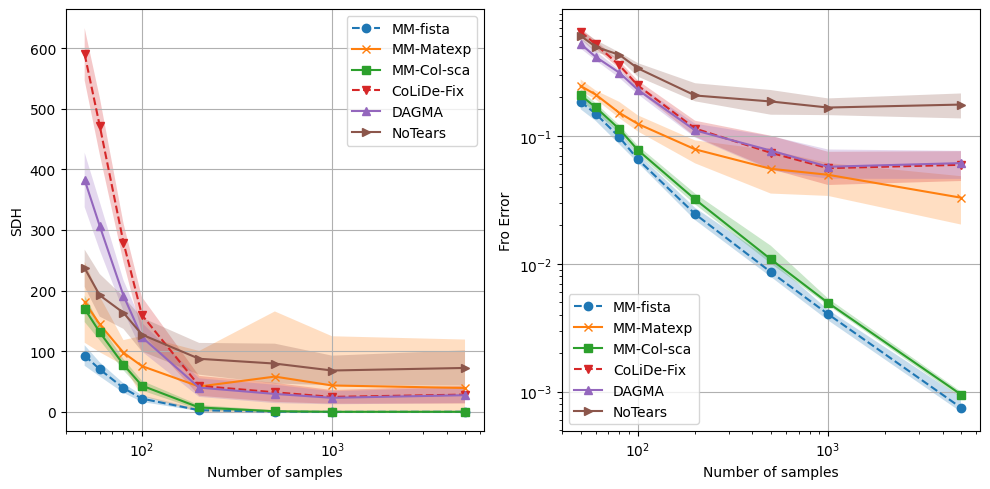

In [7]:
if SAVE:
    file_name = PATH + f'samples_{N}N_{int(data_p["edges"]/N)}'
    np.savez(file_name, shd=shd, tpr=tpr, fdr=fdr, fscore=fscore, err=err,
             acyc=acyc, runtime=runtime, dag_count=dag_count, exps=Exps,
             xvals=N_samples)
    print('SAVED in file:', file_name)

    agg_error = np.median(err, axis=0)
    utils.data_to_csv(f'{PATH}samples_err_med.csv', Exps, N_samples, agg_error)
    prctile25 = np.percentile(err, 25, axis=0)
    utils.data_to_csv(f'{PATH}samples_err_prctile25.csv', Exps, N_samples, prctile25)
    prctile75 = np.percentile(err, 75, axis=0)
    utils.data_to_csv(f'{PATH}samples_err_prctile75.csv', Exps, N_samples, prctile75)

    agg_shd = np.mean(err, axis=0)
    utils.data_to_csv(f'{PATH}samples_shd_mean.csv', Exps, N_samples, agg_shd)
    std_shd = np.std(err, axis=0)
    utils.data_to_csv(f'{PATH}samples_shd_std.csv', Exps, N_samples, std_shd)

skip = [0, 5]  # [1, 4]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
utils.plot_data(axes[0], shd, Exps, N_samples, 'Number of samples', 'SDH', skip,
                agg='mean', deviation='std', alpha=0.25)
utils.plot_data(axes[1], err, Exps, N_samples, 'Number of samples', 'Fro Error', skip,
                agg='median', deviation='prctile', alpha=0.25, plot_func='loglog')
plt.tight_layout()



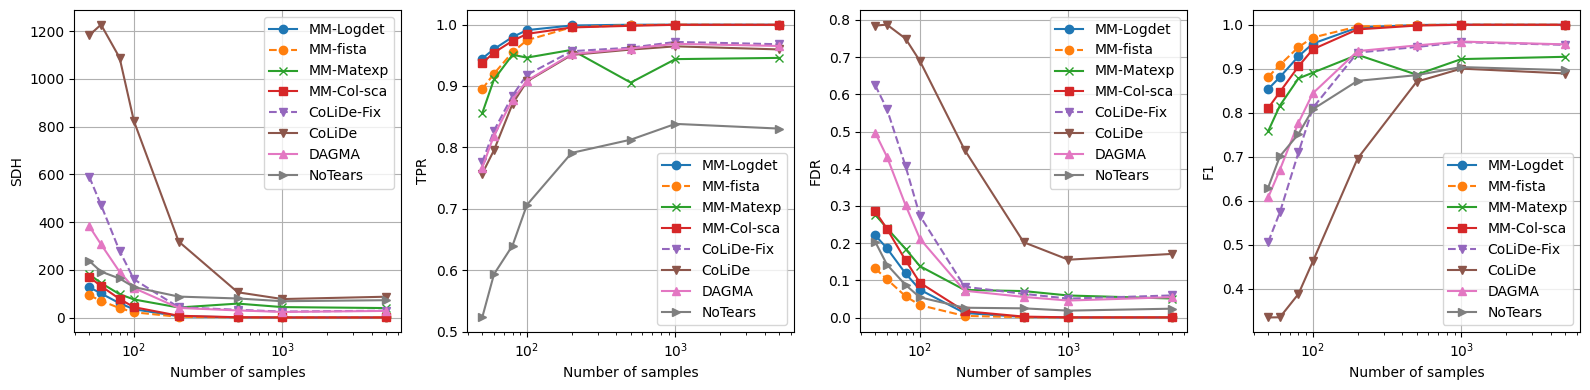

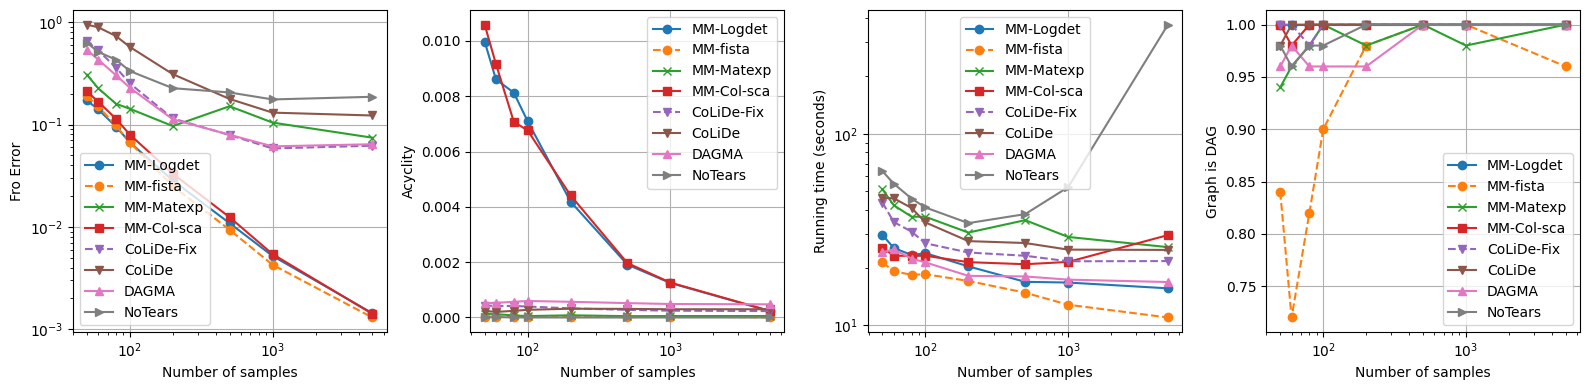

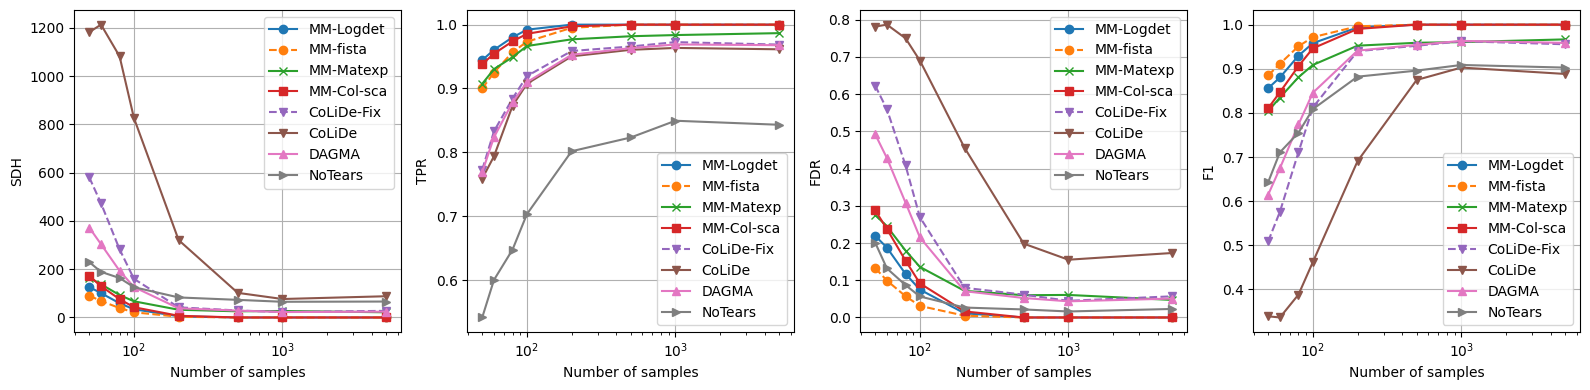

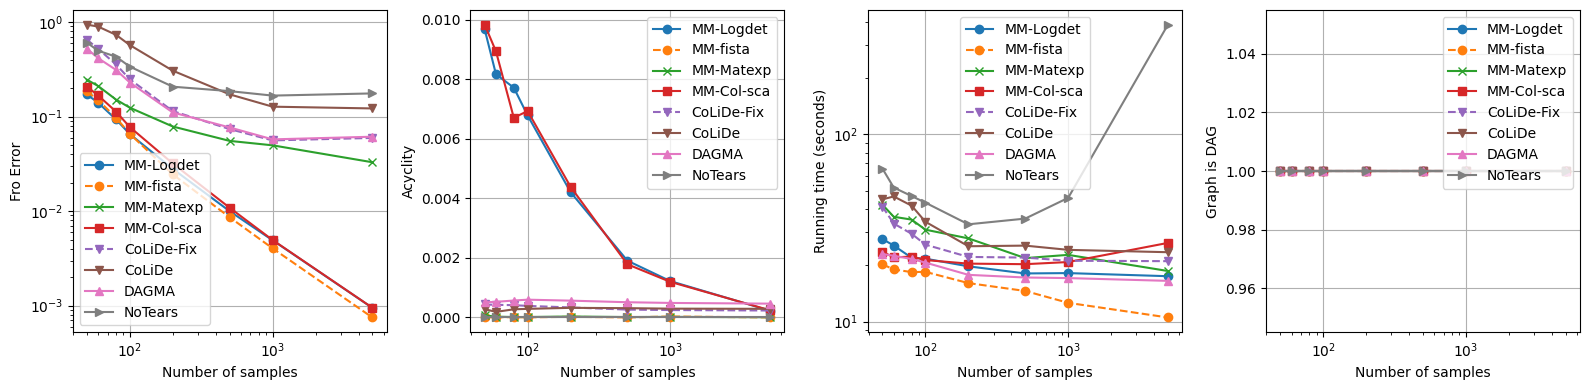

In [8]:
skip = [] # [2]
utils.plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, N_samples, Exps,
                 skip_idx=skip, agg='mean')

utils.plot_all_metrics(shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, N_samples, Exps,
                 skip_idx=skip, agg='median')


In [9]:
# # Load Data
# file_name = "./results/samples/samples_4N.npz"
# data = np.load(file_name, allow_pickle=True)
# Exps = data['exps']
# shd = data['shd']
# err = data['err']
# N_samples = data['xvals']

### 2N Edges 

In [10]:
N = 100
thr = .2
verb = False
data_p = {
    'n_nodes': N,
    'graph_type': 'er',
    'edges': 2*N,
    'edge_type': 'positive',
    'w_range': (.5, 1),
    'var': 1,
}


shd, tpr, fdr, fscore, err, acyc, runtime, dag_count =\
      [np.zeros((n_dags, len(N_samples), len(Exps)))  for _ in range(8)]

print('CPUs employed:', N_CPUS)

t_init = perf_counter()
results = Parallel(n_jobs=N_CPUS)(delayed(run_samples_exp)
                                  (g, data_p, N_samples, Exps, thr, verb) for g in range(n_dags))
t_end = perf_counter()
print(f'----- Solved in {(t_end-t_init)/60:.3f} minutes -----')
shd, tpr, fdr, fscore, err, acyc, runtime, dag_count = zip(*results)


CPUs employed: 128
Graph: 1, samples: 50
Graph: 1, samples: 60
Graph: 1, samples: 80
Graph: 1, samples: 100
Graph: 1, samples: 200
Graph: 1, samples: 500
Graph: 1, samples: 1000
Graph: 1, samples: 5000
----- Solved in 22.860 minutes -----


SAVED in file: ./results/samples/samples_100N_2


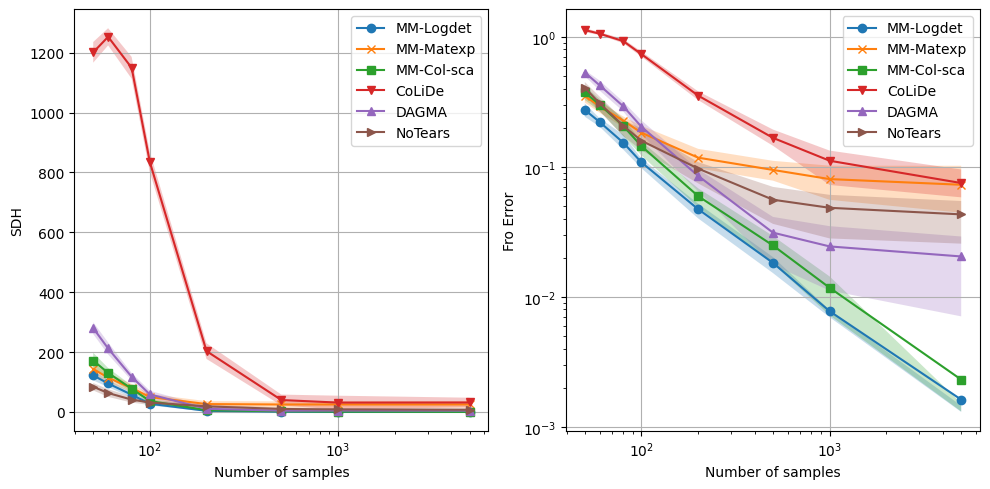

In [11]:
if SAVE:
    file_name = PATH + f'samples_{N}N_{int(data_p["edges"]/N)}'
    np.savez(file_name, shd=shd, tpr=tpr, fdr=fdr, fscore=fscore, err=err,
             acyc=acyc, runtime=runtime, dag_count=dag_count, exps=Exps,
             xvals=N_samples)
    print('SAVED in file:', file_name)
    
skip = [1, 4]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
utils.plot_data(axes[0], shd, Exps, N_samples, 'Number of samples', 'SDH', skip,
                agg='mean', deviation='std', alpha=0.25)
utils.plot_data(axes[1], err, Exps, N_samples, 'Number of samples', 'Fro Error', skip,
                agg='mean', deviation='prctile', alpha=0.25, plot_func='loglog')
plt.tight_layout()


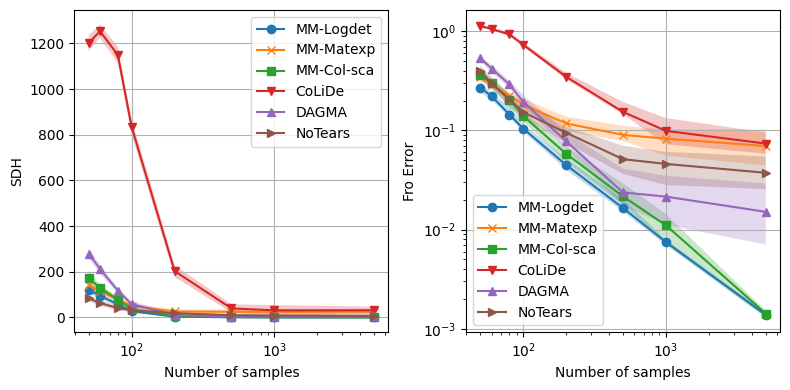

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
utils.plot_data(axes[0], shd, Exps, N_samples, 'Number of samples', 'SDH', skip,
                agg='mean', deviation='std', alpha=0.25)
utils.plot_data(axes[1], err, Exps, N_samples, 'Number of samples', 'Fro Error', skip,
                agg='median', deviation='prctile', alpha=0.25, plot_func='loglog')
plt.tight_layout()
